# Maximum probability of loss

We are investing in two assets. Let $R_1$ and $R_2$ be the random variables corresponding to the returns. Both $R_1$ and $R_2$ have Gaussian marginal distributions, with known means $\mu_1=5$ and $\mu_2=15$ and known standard deviations $\sigma_1=3$ and $\sigma_2=10$. Moreover, we are given the correlation coefficient $\rho=-0.3$, i.e.,$$\mathbf{E} (R_1-\mu_1) (R_2-\mu_2)  = \rho \sigma_1 \sigma_2.$$

Use a linear programming solver to find the worst-case (maximum) probability of a loss, i.e, $p^\mathrm{loss} = \mathbf{Pr} (R_1+R_2 \leq 0)$. Compare the results to the case when $R_1$ and $R_2$ are jointly Gaussian.  Then,
  
  $$R_1+R_2 \sim \mathcal N(\mu_1+\mu_2,\sigma_1^2+\sigma_2^2+2 \rho \sigma_1\sigma_2),$$
  
  which for our parameters gives $p^\mathrm{loss} \approx 0.018$. 
  
This is an infinite-dimensional optimization problem, since you must maximize $p^\mathrm{loss}$ over an infinite-dimensional set of joint distributions. To (approximately) solve it, we discretize the values that $R_1$ and $R_2$ can take on, to $n=100$ values $r_1,\ldots, r_n$, uniformly spaced from $r_1=-20$ to $r_n=+50$. 
We use the discretized marginals $p^{(1)}$ and $p^{(2)}$ for $R_1$ and $R_2$, given by$$p^{(k)}_i =\mathbf{Pr}(R_k = r_i) =\frac{ \exp \left(-(r_i-\mu_k)^2/(2 \sigma_k^2) \right)}{\sum_{j=1}^n  \exp \left( -(r_j-\mu_k)^2/(2 \sigma_k^2) \right)},$$
  for $k=1,2$, $i=1, \ldots, n$.
  
  Plot the joint distribution that yields the maximum value of $p^\mathrm{loss}$ using e.g. ``matplotlib``'s ``contour`` (see the code below for two jointly Gaussian variables). Interpret what you see. 
  
  ---- 
*This exercise originates from "Additional Exercises" collection for Convex Optimization textbook of S. Boyd and L. Vandenberghe. Used under permission*

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
mu = (5.0, 15.0)
sigma = (3.0, 10.0)
rho = -0.3
n = 100
r=np.linspace(-20,50,n)

Below we create the marginals of the discrete distrubution

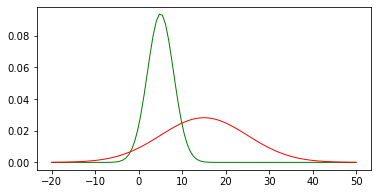

In [3]:
e = lambda k, i : math.exp(-(r[i]-mu[k])**2 / (2*sigma[k]**2))
p_mar = np.zeros((n,n))
for k in [0,1]:
    sum_exp = sum(e(k,i) for i in range(100))
    for i in range(n):
        p_mar[k][i] = e(k,i)/sum_exp

plt.rcParams['figure.figsize'] = [6, 3]
fig = plt.figure()
plt.plot(r,p_mar[0], 'g', linewidth=1)
plt.plot(r,p_mar[1], 'r', linewidth=1)

Let's also draw the joint Gaussian distribution, just for fun.

In [4]:
#calculate probability of loss
from scipy.stats import norm
norm.cdf(0, sum(mu), math.sqrt(sigma[0]**2 + sigma[1]**2 + 2*rho*sigma[0]*sigma[1]))

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


0.018015843109116775

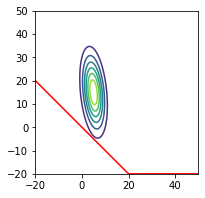

In [5]:
from scipy.stats import multivariate_normal

# Initializing the covariance matrix
cov = np.array([[sigma[0]**2, rho*sigma[0]*sigma[1]], [rho*sigma[0]*sigma[1], sigma[1]**2]])

# Generating a Gaussian bivariate distribution
# with given mean and covariance matrix
distr = multivariate_normal(cov = cov, mean = mu)

# Generating a meshgrid complacent with
# the 3-sigma boundary
X, Y = np.meshgrid(r,r)

# Generating the density function
# for each point in the meshgrid
pdf = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])

plt.axes().set_aspect('equal')
plt.contour(X, Y, pdf)
plt.plot(r,list(map(lambda x: max(x,-20), -r)),color="r") #R1+R2==0 red line


Above one can see that the two variables are indeed negatively correlated. 
The region below the red line is the loss event (we see that it is indeed unlikely)

## Solution

Because we interpret $R_1$ and $R_2$ discretely, we have:
$$p^\mathrm{loss} = \mathbf{Pr} (R_1+R_2 \leq 0) = \sum_{\substack{i,j\in\{1,\ldots,n\}\\ r_i + r_j \leq 0}} \mathbf{Pr}(R_1 = r_i, R_2 = r_j)$$
Therefore, our objective is to maximize this sum.


Let's consider our constraints in our discrete case:$\\$
At first, we have
$$p_i^{(1)} = \mathbf{Pr}(R_1 = r_i) = \sum_{j=1}^n \mathbf{Pr}(R_1 = r_i, R_2 = r_j)\hspace{3cm} p_i^{(2)} = \mathbf{Pr}(R_2 = r_i) = \sum_{j=1}^n \mathbf{Pr}(R_2 = r_i, R_1 = r_j)$$

The next constraint is:


$$\rho \sigma_1 \sigma_2  = \mathbf{E} (R_1-\mu_1) (R_2-\mu_2)  = \sum_{i,j\in{1,\ldots,n}} (r_i - \mu_1)(r_j-\mu_2)\cdot\mathbf{Pr}(R_1 = i, R_2 = j)$$


Now, if we consider an $n\times n$ matrix $P = (p_{ij})$, where $p_{ij} = \mathbf{Pr}(R_1 = i, R_2 = j)$, we can write constraints as follows:
  * $p^{(1)} = P \cdot 1,\hspace{3mm} p^{(2)} = P^{T} \cdot 1$
  * $\rho \sigma_1 \sigma_2 = (r - \mu_1\cdot 1)^{T}P(r - \mu_2\cdot 1)$
  * $0 \preceq P \preceq 1$

In [6]:
# Let x be such a matrix of elements in {0,1} that ||x * p||^2 = (p_loss)
x = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if (r[i] + r[j] <= 0):
            x[i, j] = 1

In [17]:
import cvxpy as cp

p = cp.Variable((n, n), name='p')

constraints = [p @ np.ones(n) == p_mar[0],
               p.T @ np.ones(n) == p_mar[1],
               p >= 0,
               p <= 1]

obj = cp.Maximize(cp.sum(cp.multiply(x, p)))

prob = cp.Problem(obj, constraints)
prob.solve(verbose=True,solver=cp.GUROBI)
print("max p loss", prob.value)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Apr 26 12:58:14 PM: Your problem has 10000 variables, 4 constraints, and 0 parameters.
(CVXPY) Apr 26 12:58:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 26 12:58:14 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 26 12:58:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 26 12:58:14 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 26 12:58:14 PM: Compiling problem (target solver=GUROBI).

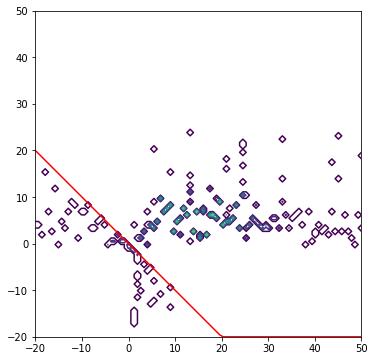

In [8]:
plt.figure(figsize=(10, 6))
plt.axes().set_aspect('equal')
plt.contour(X, Y, p.value)
plt.plot(r,list(map(lambda x: max(x,-20), -r)),color="r") #R1+R2==0 red line

# Interpretation

We can observe that for $R1 + R2 < 0$, the distribution plot is almost symmetric about the $x=y$ axis for intermediate values. However, for extreme values, we clearly have a higher event density for $R1 \approx 10$ than $R2 \approx 10$, as expected from the distributions of $R1$ and $R2$, where $R2$ takes values $(-10, -4)$ with a higher probability than $R1$. Looking at the entire plot, we see that almost the entire distribution of $R1$ lies within the range $(-4, 10)$, consistent with its distribution. The only deviations from this are the elements for $R1 \approx -10$ and $R1 \approx 20$. Furthermore, we observe that events where $R1 + R2 < 0$ are close to the axis $R1 + R2 = 0$, which seems intuitive for optimal solutions.